In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15406033026645884796
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10164724876757140394
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16559829886605268262
physical_device_desc: "device: XLA_GPU device"
]


In [28]:
np.random.seed(123)
tf.random.set_seed(123)

n_steps=5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(16))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
for idx, (X_batch) in enumerate(dataset):
    print('X_batch:',X_batch)

X_batch: <_VariantDataset shapes: (), types: tf.int32>
X_batch: <_VariantDataset shapes: (), types: tf.int32>
X_batch: <_VariantDataset shapes: (), types: tf.int32>
X_batch: <_VariantDataset shapes: (), types: tf.int32>
X_batch: <_VariantDataset shapes: (), types: tf.int32>
X_batch: <_VariantDataset shapes: (), types: tf.int32>


In [29]:
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
for idx, (X_batch) in enumerate(dataset):
    print('X_batch:',X_batch)

X_batch: tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
X_batch: tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int32)
X_batch: tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int32)
X_batch: tf.Tensor([ 6  7  8  9 10], shape=(5,), dtype=int32)
X_batch: tf.Tensor([ 8  9 10 11 12], shape=(5,), dtype=int32)
X_batch: tf.Tensor([10 11 12 13 14], shape=(5,), dtype=int32)


In [30]:
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for idx, (X_batch, y_batch) in enumerate(dataset):
    print('X_batch:',X_batch)
    print('y_batch:',y_batch)

X_batch: tf.Tensor(
[[10 11 12 13]
 [ 2  3  4  5]
 [ 8  9 10 11]], shape=(3, 4), dtype=int32)
y_batch: tf.Tensor(
[[11 12 13 14]
 [ 3  4  5  6]
 [ 9 10 11 12]], shape=(3, 4), dtype=int32)
X_batch: tf.Tensor(
[[0 1 2 3]
 [4 5 6 7]
 [6 7 8 9]], shape=(3, 4), dtype=int32)
y_batch: tf.Tensor(
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 7  8  9 10]], shape=(3, 4), dtype=int32)


# **CharRNN - Shakespeare_Dataset**

In [32]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file('shakespeare.txt', shakespeare_url)
filepath

1122304/1115394 [==============================] - 15s 13us/step


'C:\\Users\\user\\.keras\\datasets\\shakespeare.txt'

In [33]:
with open(filepath) as f:
    shakespeare_txt = f.read()

In [37]:
print(shakespeare_txt[:140])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to 


In [39]:
''.join(sorted(set(shakespeare_txt.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [40]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_txt)

In [42]:
tokenizer.texts_to_sequences(['first'])

[[20, 6, 9, 8, 3]]

In [44]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [46]:
max_id = tokenizer.word_index
max_id

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'i': 6,
 'h': 7,
 's': 8,
 'r': 9,
 'n': 10,
 '\n': 11,
 'l': 12,
 'd': 13,
 'u': 14,
 'm': 15,
 'y': 16,
 'w': 17,
 ',': 18,
 'c': 19,
 'f': 20,
 'g': 21,
 'b': 22,
 'p': 23,
 ':': 24,
 'k': 25,
 'v': 26,
 '.': 27,
 "'": 28,
 ';': 29,
 '?': 30,
 '!': 31,
 '-': 32,
 'j': 33,
 'q': 34,
 'x': 35,
 'z': 36,
 '3': 37,
 '&': 38,
 '$': 39}

In [47]:
max_id = len(max_id)

In [48]:
dataset_size = tokenizer.document_count
dataset_size

1115394

In [90]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_txt]))-1
encoded[:100]

array([19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
       19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
        9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0,
       14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7,
       22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,
        7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13])

In [144]:
train_size = dataset_size*15//100
print(train_size)
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

167309


In [145]:
for x in dataset.take(2):
    print(x)

tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [146]:
n_steps=100
windows_length=n_steps+1
batch_size=32
dataset = dataset.repeat().window(windows_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(windows_length))
dataset = dataset.map(lambda window: (window[:-1], window[1:])).shuffle(10000).batch(batch_size)

In [147]:
for x,y in dataset.take(2):
    print('\nX_batch:',x)
    print('Y_batch:',y)


X_batch: tf.Tensor(
[[ 8  5 18 ... 14  5  2]
 [ 2  6  1 ... 12  5 12]
 [ 1  1  0 ...  1  0 19]
 ...
 [12 26  0 ... 13  0  4]
 [15  0 25 ...  3  0 21]
 [ 6  1  0 ...  1 11 22]], shape=(32, 100), dtype=int32)
Y_batch: tf.Tensor(
[[ 5 18  5 ...  5  2 15]
 [ 6  1  0 ...  5 12  0]
 [ 1  0 16 ...  0 19 11]
 ...
 [26  0  6 ...  0  4  8]
 [ 0 25  1 ...  0 21  8]
 [ 1  0  4 ... 11 22  7]], shape=(32, 100), dtype=int32)

X_batch: tf.Tensor(
[[ 3 16  0 ... 12  0  1]
 [ 5  9 24 ...  5 14  1]
 [ 2  5 35 ...  5  9  0]
 ...
 [ 7  1  9 ... 12  0  2]
 [ 0  1  4 ...  1  7  7]
 [ 0  5 14 ...  8 14  7]], shape=(32, 100), dtype=int32)
Y_batch: tf.Tensor(
[[16  0  5 ...  0  1  7]
 [ 9 24  0 ... 14  1  0]
 [ 5 35  1 ...  9  0  8]
 ...
 [ 1  9  4 ...  0  2  6]
 [ 1  4  2 ...  7  7  0]
 [ 5 14 22 ... 14  7 17]], shape=(32, 100), dtype=int32)


In [148]:
dataset = dataset.map(lambda X_batch, y_batch: (tf.one_hot(X_batch, depth=max_id), y_batch))
dataset = dataset.prefetch(1)

In [149]:
for x,y in dataset.take(1):
    print('\nX_batch:',x)
    print('Y_batch:',y)
    print(x.shape, y.shape)


X_batch: tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0

In [150]:
model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, None, 64)          20160     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 39)          2535      
Total params: 22,695
Trainable params: 22,695
Non-trainable params: 0
_________________________________________________________________


In [151]:
with tf.device('/device:GPU:0'):
    history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=2)

Train for 5228 steps
Epoch 1/2
5228/5228 [==============================] - 184s 35ms/step - loss: 2.0332
Epoch 2/2
5228/5228 [==============================] - 170s 33ms/step - loss: 1.8139


In [153]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [156]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
Y_pred

array([[ 1, 13,  0,  2,  9,  1,  0,  2,  3, 13]], dtype=int64)

In [162]:
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [138]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [163]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [187]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [166]:
print(complete_text("t", temperature=2))

tycc ba
doveay enerobpance, cra
vijoevins! drazeryp


## Stateful RNN

In [152]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(windows_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(windows_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda window: (window[:-1], window[1:]))
dataset = dataset.map(lambda X_batch, y_batch:
                                         (tf.one_hot(X_batch, depth=max_id), y_batch))
dataset = dataset.prefetch(1)

In [168]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(windows_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(windows_length))
    datasets.append(dataset)

dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [177]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(64, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [178]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (32, None, 128)           64896     
_________________________________________________________________
gru_17 (GRU)                 (32, None, 64)            37248     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 39)          2535      
Total params: 104,679
Trainable params: 104,679
Non-trainable params: 0
_________________________________________________________________


In [179]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [181]:
with tf.device('/device:GPU:0'):
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    steps_per_epoch = train_size // batch_size // n_steps   # Becoz shift=m_steps (train_size/(n_steps*batch_size))
    history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=7,
                        callbacks=[ResetStatesCallback()])

Train for 52 steps
Epoch 1/7
52/52 [==============================] - 48s 924ms/step - loss: 3.6636
Epoch 2/7
52/52 [==============================] - 40s 772ms/step - loss: 3.6636
Epoch 3/7
52/52 [==============================] - 39s 750ms/step - loss: 3.6636
Epoch 4/7
52/52 [==============================] - 38s 735ms/step - loss: 3.6636
Epoch 5/7
52/52 [==============================] - 39s 755ms/step - loss: 3.6636
Epoch 6/7
52/52 [==============================] - 38s 730ms/step - loss: 3.6636
Epoch 7/7
52/52 [==============================] - 38s 729ms/step - loss: 3.6636


In [182]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [183]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [184]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

# Sentiment Analysis

In [4]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 121s 7us/step


In [54]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [58]:
word_idx = keras.datasets.imdb.get_word_index()
id2word = {id_+ 3 : word for word, id_ in word_idx.items()}
for id_, word in enumerate(('<pad>', '<sos>', '<unk>')):
    id2word[id_]=word

' '.join([id2word[id_] for id_ in X_train[0]])

1646592/1641221 [==============================] - 36s 22us/step


"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [5]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to C:\Users\user\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteHI5H61\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\user\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteHI5H61\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\user\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteHI5H61\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\user\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [6]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [7]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples
train_size, test_size

(25000, 25000)

In [10]:
for X_batch, y_batch in datasets['train'].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print('Review: ', review.decode('utf-8')[:250],'.....')
        print('Label: ', label, '\n')

Review:  This is a big step down after the surprisingly enjoyable original. This sequel isn't nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is  .....
Label:  0 

Review:  Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian school, so I am not sure what effect it would have on m .....
Label:  0 



In [15]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b'<br\s*/?>', b' ')
    X_batch = tf.strings.regex_replace(X_batch, b'[^a-zA-Z]', b' ')
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value='<pad>'), y_batch

In [16]:
preprocess(X_batch, y_batch)

(<tf.Tensor: id=394, shape=(2, 61), dtype=string, numpy=
 array([[b'This', b'is', b'a', b'big', b'step', b'down', b'after', b'the',
         b'surprisingly', b'enjoyable', b'original', b'This', b'sequel',
         b'isn', b't', b'nearly', b'as', b'fun', b'as', b'part', b'one',
         b'and', b'it', b'instead', b'spends', b'too', b'much', b'time',
         b'on', b'plot', b'development', b'Tim', b'Thomerson', b'is',
         b'still', b'the', b'best', b'thing', b'about', b'this',
         b'series', b'but', b'his', b'wisecracking', b'is', b'toned',
         b'down', b'in', b'this', b'entry', b'The', b'performances',
         b'are', b'all', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>'],
        [b'Perhaps', b'because', b'I', b'was', b'so', b'young',
         b'innocent', b'and', b'BRAINWASHED', b'when', b'I', b'saw',
         b'it', b'this', b'movie', b'was', b'the', b'cause', b'of',
         b'many', b'sleepless', b'nights', b'for', b'me', b'I', b'hav

In [17]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets['train'].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [18]:
vocabulary.most_common()[:5]

[(b'<pad>', 223998),
 (b'the', 61156),
 (b'a', 38569),
 (b'of', 33984),
 (b'and', 33432)]

In [19]:
len(vocabulary)

49739

In [35]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]
truncated_vocabulary[:5], len(truncated_vocabulary)

([b'<pad>', b'the', b'a', b'of', b'and'], 10000)

In [42]:
word_to_id = {word: idx for idx, word in enumerate(truncated_vocabulary)}

In [44]:
for word in b"This movie we do itt".split():
    print(word_to_id.get(word) or vocab_size, end='\t')

24	12	108	105	10000	

In [47]:
words=tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
oov_buckets=1000
table = tf.lookup.StaticVocabularyTable(vocab_init, oov_buckets)

In [48]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: id=102106, shape=(1, 4), dtype=int64, numpy=array([[   24,    12,    13, 10053]], dtype=int64)>

In [49]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [50]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[   24     7     2 ...     0     0     0]
 [ 1230    83     5 ...    31  4258     0]
 [ 4112     3     1 ...     0     0     0]
 ...
 [   24     7    25 ...     0     0     0]
 [ 1292  3544     7 ...     0     0     0]
 [10928 10687  4552 ...     0     0     0]], shape=(32, 62), dtype=int64)
tf.Tensor([0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1], shape=(32,), dtype=int64)


In [61]:
valid_set = datasets['test'].take(2000).repeat().batch(32).map(preprocess)
valid_set = valid_set.map(encode_words).prefetch(1)

In [70]:
for x, y in valid_set.take(1):
    print(x,y)

tf.Tensor(
[[  29 1794   17 ...    0    0    0]
 [   5  264  254 ...    0    0    0]
 [  24  323   16 ...    0    0    0]
 ...
 [  15   95  167 ...    0    0    0]
 [ 159    7  340 ...    0    0    0]
 [   5  100   10 ...    2  105    0]], shape=(32, 62), dtype=int64) tf.Tensor([1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1], shape=(32,), dtype=int64)


In [64]:
embed_size = 128
model = keras.models.Sequential([
# mask_zero=True means word that mapped as 0 is gonna get neglect in its time step and previous hidden state would be moved
    keras.layers.Embedding(vocab_size + oov_buckets, embed_size, mask_zero=True, input_shape=[None]),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1, activation="sigmoid")
])

root_dir = os.path.join(os.curdir, 'my_logs')
tensorboard_callback = keras.callbacks.TensorBoard(root_dir)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1408000   
_________________________________________________________________
gru_4 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,454,689
Trainable params: 1,454,689
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(train_set, steps_per_epoch = train_size//32,
                    validation_data=valid_set, validation_steps=2000//32,
                    epochs=5, callbacks=[tensorboard_callback])

Train for 781 steps, validate for 62 steps
Epoch 1/5
781/781 [==============================] - 117s 150ms/step - loss: 0.5327 - accuracy: 0.7284 - val_loss: 0.4999 - val_accuracy: 0.7591
Epoch 2/5
781/781 [==============================] - 74s 95ms/step - loss: 0.3502 - accuracy: 0.8581 - val_loss: 0.5479 - val_accuracy: 0.7480
Epoch 3/5
781/781 [==============================] - 70s 89ms/step - loss: 0.2095 - accuracy: 0.9255 - val_loss: 0.6583 - val_accuracy: 0.7329
Epoch 4/5
781/781 [==============================] - 66s 85ms/step - loss: 0.1521 - accuracy: 0.9461 - val_loss: 0.7532 - val_accuracy: 0.7349
Epoch 5/5
781/781 [==============================] - 61s 78ms/step - loss: 0.0965 - accuracy: 0.9683 - val_loss: 1.0095 - val_accuracy: 0.7389


In [82]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(64, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(32)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 128)    1408000     input_7[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None)         0           input_7[0][0]                    
__________________________________________________________________________________________________
gru_14 (GRU)                    (None, None, 64)     37248       embedding_7[0][0]                
____________________________________________________________________________________________

In [83]:
history = model.fit(train_set, steps_per_epoch = train_size//32,
                    validation_data=valid_set, validation_steps=2000//32,
                    epochs=3, callbacks=[tensorboard_callback])

Train for 781 steps, validate for 62 steps
Epoch 1/3
781/781 [==============================] - 92s 118ms/step - loss: 0.5313 - accuracy: 0.7242 - val_loss: 0.4972 - val_accuracy: 0.7641
Epoch 2/3
781/781 [==============================] - 46s 58ms/step - loss: 0.3498 - accuracy: 0.8550 - val_loss: 0.5538 - val_accuracy: 0.7485
Epoch 3/3
781/781 [==============================] - 36s 47ms/step - loss: 0.2054 - accuracy: 0.9260 - val_loss: 0.6493 - val_accuracy: 0.7243


## Reusing Pretrained Embedding

In [88]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, 'my_tfhub_cache')
os.environ['TFHUB_CACHE_DIR'] = TFHUB_CACHE_DIR

In [96]:
import tensorflow_hub as hub

model = keras.Sequential([
    # 1 at the end means version 1
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_17 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 48,197,257
Trainable params: 6,657
Non-trainable params: 48,190,600
_________________________________________________________________


In [94]:
for dirpath, dirname, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\saved_model.pb
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\assets\tokens.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.data-00000-of-00001
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.index


In [95]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
valid_set = datasets['test'].take(2000).repeat().batch(batch_size).prefetch(1)

history = model.fit(train_set, steps_per_epoch=train_size // batch_size,
                    validation_data=valid_set, validation_steps=2000//batch_size, epochs=5)

Train for 781 steps, validate for 62 steps
Epoch 1/5
781/781 [==============================] - 28s 36ms/step - loss: 0.5484 - accuracy: 0.7233 - val_loss: 0.5333 - val_accuracy: 0.7384
Epoch 2/5
781/781 [==============================] - 26s 33ms/step - loss: 0.5146 - accuracy: 0.7490 - val_loss: 0.5265 - val_accuracy: 0.7450
Epoch 3/5
781/781 [==============================] - 26s 33ms/step - loss: 0.5091 - accuracy: 0.7520 - val_loss: 0.5238 - val_accuracy: 0.7475
Epoch 4/5
781/781 [==============================] - 25s 31ms/step - loss: 0.5054 - accuracy: 0.7554 - val_loss: 0.5204 - val_accuracy: 0.7510
Epoch 5/5
781/781 [==============================] - 24s 31ms/step - loss: 0.5022 - accuracy: 0.7562 - val_loss: 0.5168 - val_accuracy: 0.7550


# Automatic Translation

In [3]:
vocab_size = 100
embed_size = 10

In [12]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(128)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)

f_output, f_state, f_seq_len = decoder(decoder_embeddings, training=True,
                                       initial_state=encoder_state, sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(f_output.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths], 
                          outputs=[Y_proba])

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 2s 66ms/step - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 2s 58ms/step - loss: 4.6037


## Bidirectional Cells

In [6]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Positional Encoding

In [21]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_dims, max_steps, dtype=tf.float32, **kwargs):
        super(PositionalEncoding, self).__init__(dtype=dtype, **kwargs)
        if max_dims%2 ==1: max_dims+=1
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims//2))
        pos = np.empty((1, max_steps, max_dims))
        pos[0, :, ::2] = np.sin(p/(10000**(2*i/max_dims))).T
        pos[0, :, 1::2] = np.cos(p/(10000**(2*i/max_dims))).T
        self.position_embed = tf.constant(pos.astype(dtype=self.dtype))
    def call(self, inputs):
        shape=tf.shape(inputs)
        return inputs + self.position_embed[:, :shape[-2], :shape[-1]]

In [22]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_dims, max_steps)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

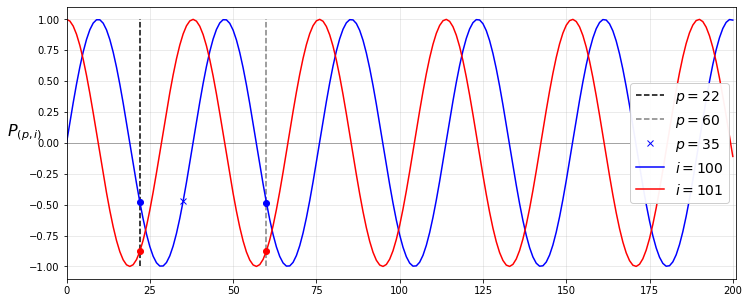

In [33]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
plt.figure(figsize=(12, 5))
plt.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
plt.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
plt.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
plt.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
plt.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
plt.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
plt.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
plt.legend(loc="center right", fontsize=14, framealpha=0.95)
plt.xlim((0, 201))
plt.ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
plt.grid(True, alpha=0.3)
plt.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
plt.show()

In [42]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_dims=embed_size, max_steps=max_steps)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

In [43]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
                            keras.layers.Dense(vocab_size, activation='softmax'))(Z)

In [44]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], 
                          outputs=[outputs])

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 512)    5120000     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
positional_encoding_7 (Position (None, None, 512)    0           embedding_3[0][0]          

# Date Format Converter

In [2]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()
    ordinals = np.random.randint(max_date-min_date, size=n_dates)+min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]
    X = [MONTHS[dt.month - 1] + ' ' + dt.strftime('%d, %Y') for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return X, y

In [3]:
np.random.seed(123)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
February 17, 3118        3118-02-17               
October 12, 1760         1760-10-12               
September 29, 1076       1076-09-29               


In [4]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

In [5]:
OUTPUT_CHARS = "0123456789-"

In [6]:
INPUT_CHARS.index('A')

0

In [7]:
def date_str_to_ids(dt_str, chars=INPUT_CHARS):
    return [chars.index(d) for d in dt_str]

In [8]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[2, 11, 9, 20, 23, 8, 20, 25, 38, 27, 33, 37, 38, 29, 27, 27, 34]

In [50]:
x_example[0]

'February 17, 3118'

In [51]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[3, 1, 1, 8, 10, 0, 2, 10, 1, 7]

In [52]:
y_example[0]

'3118-02-17'

In [53]:
tf.ragged.constant([[[1,2,3,4],[1,2], [1,3, 5], [4]],[[1], [2,5], [1,3,5,3]]], ragged_rank=2)

<tf.RaggedTensor [[[1, 2, 3, 4], [1, 2], [1, 3, 5], [4]], [[1], [2, 5], [1, 3, 5, 3]]]>

In [9]:
def prepare_date_strs(date_str, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_str]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X+1).to_tensor() # using 0 as the padding token

def create_dataset(n_dates):
    X,y = random_dates(n_dates)
    return prepare_date_strs(X, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [10]:
np.random.seed(123)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [77]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(123)
tf.random.set_seed(123)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim = len(INPUT_CHARS)+1, 
                           output_dim=embedding_size, input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS)+1, activation='softmax')
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length), # Repeat the output of the encoder to the decoder 
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 128)               83712     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 10, 12)            133132    
Total params: 216,844
Trainable params: 216,844
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 26s 81ms/step - loss: 1.8369 - accuracy: 0.3407 - val_loss: 1.5001 - val_accuracy: 0.4459
Epoch 2/20
313/313 [==============================] - 23s 73ms/step - loss: 1.3002 - accuracy: 0.5215 - val_loss: 1.1315 - val_accuracy: 0.5938
Epoch 3/20
313/313 [==============================] - 23s 74ms/step - loss: 1.1204 - accuracy: 0.6066 - val_loss: 0.8853 - val_accuracy: 0.6777
Epoch 4/20
313/313 [==============================] - 21s 67ms/step - loss: 0.7481 - accuracy: 0.7182 - val_loss: 0.6499 - val_accuracy: 0.7481
Epoch 5/20
313/313 [==============================] - 22s 71ms/step - loss: 0.9049 - accuracy: 0.6725 - val_loss: 0.6976 - val_accuracy: 0.7385
Epoch 6/20
313/313 [==============================] - 22s 71ms/step - loss: 0.5255 - accuracy: 0.7983 - val_loss: 0.4068 - val_accuracy: 0.8457
Epoch 7/20
313/313 [==============================] - 23s 72ms/step - loss: 0.4293 - accuracy: 0.8497 - val_loss: 0.2948 - val_accuracy:

In [11]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return[''.join([('?' + chars)[index] for index in seq])
                                      for seq in ids]

In [58]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [59]:
X_new

<tf.Tensor: shape=(2, 18), dtype=int32, numpy=
array([[ 8, 12, 20, 23, 12, 17, 10, 12, 21, 39, 28, 34, 38, 39, 29, 27,
        27, 36],
       [ 4, 24, 16, 26, 39, 28, 31, 38, 39, 28, 34, 35, 36,  0,  0,  0,
         0,  0]])>

In [123]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


The model was trained on the larger sequence i.e. 18 so it won't work best for shorter sequence

In [125]:
X_new = prepare_date_strs(["July 14, 1789"])

In [126]:
X_new

<tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[ 4, 24, 16, 26, 39, 28, 31, 38, 39, 28, 34, 35, 36]])>

In [127]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1789-09-14


So we have to use padding

In [25]:
max_input_length = X_train.shape[1]

In [12]:
def prepare_date_strs_padded(date_str):
    X = prepare_date_strs(date_str)
    if X.shape[1]<max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

In [168]:
X_new = prepare_date_strs_padded(["July 14, 1789"])

In [169]:
X_new

<tf.Tensor: shape=(1, 18), dtype=int32, numpy=
array([[ 4, 24, 16, 26, 39, 28, 31, 38, 39, 28, 34, 35, 36,  0,  0,  0,
         0,  0]])>

In [170]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1789-07-14


## Teacher Feeding (Feeding shiftwd Target to the decoder)

In [13]:
sos_id = len(OUTPUT_CHARS)+1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y),1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=-1)

In [20]:
X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [62]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  4,  2, ...,  3, 11,  2],
       [12,  2,  8, ...,  1, 11,  2],
       [12,  2,  1, ..., 10, 11,  3],
       ...,
       [12,  9,  9, ...,  8, 11,  1],
       [12,  2,  4, ...,  3, 11,  1],
       [12,  2,  9, ...,  2, 11,  1]])>

In [63]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(123)
tf.random.set_seed(123)

encoder_inputs = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(input_dim = len(INPUT_CHARS)+1, 
                                           output_dim=encoder_embedding_size)(encoder_inputs)
_, encoder_h, encoder_c = keras.layers.LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_state=[encoder_h, encoder_c]

decoder_inputs = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(input_dim = len(OUTPUT_CHARS)+2, 
                                           output_dim=decoder_embedding_size)(decoder_inputs)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS)+1, activation='softmax')(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                                      outputs=[decoder_output])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, None, 32)     1280        input_13[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 32)     416         input_14[0][0]                   
____________________________________________________________________________________________

In [64]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 23s 73ms/step - loss: 1.6606 - accuracy: 0.3757 - val_loss: 1.4033 - val_accuracy: 0.4552
Epoch 2/10
313/313 [==============================] - 21s 66ms/step - loss: 1.1996 - accuracy: 0.5422 - val_loss: 0.9914 - val_accuracy: 0.6321
Epoch 3/10
313/313 [==============================] - 23s 73ms/step - loss: 0.6927 - accuracy: 0.7556 - val_loss: 0.4006 - val_accuracy: 0.8805
Epoch 4/10
313/313 [==============================] - 21s 68ms/step - loss: 0.2480 - accuracy: 0.9347 - val_loss: 0.1320 - val_accuracy: 0.9755
Epoch 5/10
313/313 [==============================] - 23s 74ms/step - loss: 0.0975 - accuracy: 0.9854 - val_loss: 0.0464 - val_accuracy: 0.9979
Epoch 6/10
313/313 [==============================] - 24s 76ms/step - loss: 0.0552 - accuracy: 0.9940 - val_loss: 0.0300 - val_accuracy: 0.9991
Epoch 7/10
313/313 [==============================] - 23s 75ms/step - loss: 0.0191 - accuracy: 0.9999 - val_loss: 0.0158 - val_accuracy:

In [14]:
sos_id = len(OUTPUT_CHARS)+1

def predict_date_strs(date_str):
    X = prepare_date_strs_padded(date_str)
    y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length-y_pred.shape[0]
        X_decoder = tf.pad(y_pred, [[0,0], [0, pad_size]])
        y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        y_pred_next = tf.argmax(y_probas_next, axis=-1, output_type = tf.int32)
        y_pred = tf.concat([y_pred, y_pred_next], axis=1)
    return ids_to_date_strs(y_pred[:, 1:])

In [76]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)
(2, 1, 12)


['1789-07-14', '2020-05-01']

## TF_Addons Basic seq2seq 

In [79]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, training=True,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)


model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, None, 32)     1280        input_18[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, None, 32)     1312        input_19[0][0]                   
____________________________________________________________________________________________

In [80]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 24s 78ms/step - loss: 1.6739 - accuracy: 0.3656 - val_loss: 1.4868 - val_accuracy: 0.4063
Epoch 2/15
313/313 [==============================] - 22s 70ms/step - loss: 1.3953 - accuracy: 0.4562 - val_loss: 1.3563 - val_accuracy: 0.4618
Epoch 3/15
313/313 [==============================] - 23s 73ms/step - loss: 1.0973 - accuracy: 0.5914 - val_loss: 0.8483 - val_accuracy: 0.7071
Epoch 4/15
313/313 [==============================] - 22s 69ms/step - loss: 0.6123 - accuracy: 0.7896 - val_loss: 0.3597 - val_accuracy: 0.8931
Epoch 5/15
313/313 [==============================] - 18s 58ms/step - loss: 0.2094 - accuracy: 0.9518 - val_loss: 0.1155 - val_accuracy: 0.9818
Epoch 6/15
313/313 [==============================] - 15s 48ms/step - loss: 0.0903 - accuracy: 0.9885 - val_loss: 0.0467 - val_accuracy: 0.9972
Epoch 7/15
313/313 [==============================] - 24s 76ms/step - loss: 0.0327 - accuracy: 0.9993 - val_loss: 0.0260 - val_accuracy:

In [85]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [93]:
# To automatically provide the last predicted class to the next time step during inference
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length) # maximum_iterations are necessary otherwise it would run on an infinite loop
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id) # start token is also important
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens, training=True,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])


## Using Seq2Seq ScheduledSampler

In [17]:
import tensorflow_addons as tfa

np.random.seed(123)
tf.random.set_seed(123)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(sampling_probability=0,
                                                                embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, training=True,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 32)     1280        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 32)     1312        input_8[0][0]                    
______________________________________________________________________________________________

In [22]:
def update_sampling_probability(epochs, logs):
    proba = min(1.0, epochs/(n_epochs-1))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(on_epoch_begin=update_sampling_probability)

In [23]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


C:\Users\user\Anaconda3\Lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 26s 84ms/step - loss: 1.6641 - accuracy: 0.3771 - val_loss: 1.3807 - val_accuracy: 0.4690
Epoch 2/20
313/313 [==============================] - 23s 74ms/step - loss: 1.1808 - accuracy: 0.5513 - val_loss: 0.9317 - val_accuracy: 0.6484
Epoch 3/20
313/313 [==============================] - 10s 33ms/step - loss: 0.7171 - accuracy: 0.7403 - val_loss: 0.5232 - val_accuracy: 0.8202
Epoch 4/20
313/313 [==============================] - 7s 22ms/step - loss: 0.3961 - accuracy: 0.8721 - val_loss: 0.2861 - val_accuracy: 0.9249
Epoch 5/20
313/313 [==============================] - 14s 46ms/step - loss: 0.2335 - accuracy: 0.9435 - val_loss: 0.2007 - val_accuracy: 0.9524
Epoch 6/20
313/313 [==============================] - 11s 36ms/step - loss: 0.1464 - accuracy: 0.9722 - val_loss: 0.1103 - val_accuracy: 0.9824
Epoch 7/20
313/313 [==============================] - 22s 71ms/step - loss: 0.1390 - accuracy: 0.9737 - val_loss: 0.0907 - val_accuracy: 0.9862
Epoc

## Using TFA seq2seq, the Keras subclassing API and attention mechanisms

In [71]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(input_dim=len(INPUT_CHARS)+1,
                                                       output_dim=encoder_embedding_size)
        self.encoder_cell = keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.decoder_embedding = keras.layers.Embedding(input_dim=len(OUTPUT_CHARS) + 2,
                                                        output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(cell=decoder_inner_cell, attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell, sampler=tfa.seq2seq.TrainingSampler(),
                                               output_layer=output_layer)
        self.inference_decoder=tfa.seq2seq.BasicDecoder(cell=self.decoder_cell, 
                                    sampler=tfa.seq2seq.GreedyEmbeddingSampler(embedding_fn=self.decoder_embedding),
                                    output_layer=output_layer, maximum_iterations=max_output_length)
    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_h, encoder_c = self.encoder_cell(encoder_embeddings, training=training)
        encoder_state = [encoder_h, encoder_c]
        self.attention(encoder_outputs, setup_memory=True)
        decoder_embeddings = self.decoder_embedding(decoder_input)
        decoder_initial_state = self.decoder_cell.get_initial_state(decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(cell_state = encoder_state)
        if training:
            decoder_outputs,_ ,_ = self.decoder(decoder_embeddings, 
                                                initial_state=decoder_initial_state, training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0])+sos_id
            decoder_outputs, _, _ = self.inference_decoder(decoder_embeddings,
                                            initial_state=decoder_initial_state, start_tokens=start_tokens, end_token=0)
        return tf.nn.softmax(decoder_outputs.rnn_output)

In [72]:
model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [73]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 23s 75ms/step - loss: 2.1298 - accuracy: 0.2349 - val_loss: 2.0020 - val_accuracy: 0.2772
Epoch 2/25
313/313 [==============================] - 26s 83ms/step - loss: 1.7828 - accuracy: 0.3580 - val_loss: 1.4823 - val_accuracy: 0.4426
Epoch 3/25
313/313 [==============================] - 25s 81ms/step - loss: 1.4399 - accuracy: 0.4754 - val_loss: 1.3733 - val_accuracy: 0.4854
Epoch 4/25
313/313 [==============================] - 22s 70ms/step - loss: 1.3929 - accuracy: 0.4979 - val_loss: 1.3458 - val_accuracy: 0.4983
Epoch 5/25
313/313 [==============================] - 13s 43ms/step - loss: 1.1730 - accuracy: 0.5750 - val_loss: 0.9184 - val_accuracy: 0.6754
Epoch 6/25
313/313 [==============================] - 14s 44ms/step - loss: 0.7885 - accuracy: 0.7300 - val_loss: 0.4729 - val_accuracy: 0.8496
Epoch 7/25
313/313 [==============================] - 25s 79ms/step - loss: 0.2604 - accuracy: 0.9270 - val_loss: 0.2213 - val_accuracy:

In [74]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [75]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']